###  Import necessary libraries

In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab import drive



Mount Google Drive to access datasets

In [2]:
# Mount Google Drive to access datasets
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load and split the dataset into training and validation/test subsets


In [3]:
# Define the dataset path and image size
dataset_path = '/content/drive/MyDrive/datasetcabee'
img_size = (224, 224)

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.10,   # Use 10% of the data for validation and testing
    subset="training",
    seed=123,
    label_mode='categorical',
    image_size=img_size,
    batch_size=None
)

val_test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.10,
    subset="validation",
    seed=123,
    label_mode='categorical',
    image_size=img_size,
    batch_size=None
)

# Split validation set into validation and test sets
val_batches = int(0.5 * len(val_test_dataset))
validation_dataset = val_test_dataset.take(val_batches)
test_dataset = val_test_dataset.skip(val_batches)



Found 1400 files belonging to 5 classes.
Using 1260 files for training.
Found 1400 files belonging to 5 classes.
Using 140 files for validation.


 Display dataset sizes

In [4]:
print("Train dataset len:", len(train_dataset))
print("Validation dataset len:", len(validation_dataset))
print("Test dataset len:", len(test_dataset))
for images, labels in train_dataset.take(1):
    print("Train dataset shape:", images.shape)
    print("Train labels shape:", labels.shape)

for images, labels in validation_dataset.take(1):
    print("Validation dataset shape:", images.shape)
    print("Validation labels shape:", labels.shape)

for images, labels in test_dataset.take(1):
    print("Test dataset shape:", images.shape)
    print("Test labels shape:", labels.shape)


Train dataset len: 1260
Validation dataset len: 70
Test dataset len: 70
Train dataset shape: (224, 224, 3)
Train labels shape: (5,)
Validation dataset shape: (224, 224, 3)
Validation labels shape: (5,)
Test dataset shape: (224, 224, 3)
Test labels shape: (5,)


### preprocess image

In [5]:
# Define a preprocessing function
def preprocess_image(image, label,prob=0.3):
    if tf.random.uniform(()) < prob:
      image=data_augmentation(image)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Define data augmentation steps
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.20),
    tf.keras.layers.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),
    tf.keras.layers.RandomBrightness(factor=0.2),
    tf.keras.layers.RandomTranslation(height_factor=(-0.1, 0.2), width_factor=(-0.1, 0.2))
])


batch_size = 64
train_data = train_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).shuffle(500).batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)
validation_data = validation_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)
test_data = test_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)


train_data_len = train_data.cardinality().numpy()



In [6]:
# Verify the structure of the batched data
image, label = next(iter(train_data.take(1)))

print("Image shape:", image.shape)
print("Pixel values (first 10 pixels after normalization):", image[0, :10, 0].numpy())


Image shape: (64, 224, 224, 3)
Pixel values (first 10 pixels after normalization): [[0.6182073  0.6260504  0.62212884]
 [0.622579   0.6304221  0.62650055]
 [0.6142857  0.62212884 0.6182073 ]
 [0.6215686  0.62941176 0.6254902 ]
 [0.6309524  0.63879555 0.634874  ]
 [0.620058   0.62790114 0.62397957]
 [0.62352943 0.6313726  0.627451  ]
 [0.61960787 0.62352943 0.6313726 ]
 [0.6313726  0.63529414 0.6431373 ]
 [0.61685675 0.6246999  0.6207783 ]]


### Load a pre-trained base model (VGG16)

In [7]:
base_model = tf.keras.applications.VGG16(
    include_top=False,   # Exclude the fully connected top layers
    weights='imagenet',  # Use weights pre-trained on ImageNet
    input_shape=(224, 224, 3)
)

# Freeze most layers in the base model
for layer in base_model.layers:
    layer.trainable = False


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### Build the custom classification model

In [8]:
from tensorflow.keras import regularizers

x=tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x=tf.keras.layers.Dense(2048,activation='relu' )(x)
x=tf.keras.layers.Dropout(0.2)(x)
x=tf.keras.layers.Dense(5,activation='softmax')(x)
model=tf.keras.models.Model(inputs=base_model.input,outputs=x)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2048)                │       1,050,6

 Total params: 15,775,557 (60.18 MB)

 Trainable params: 1,060,869 (4.05 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

# Compute class weights to handle data imbalance

In [9]:
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight

validation_labels = []

print(train_data.element_spec)
tmp=train_data.unbatch()
for img, label in tmp:

    label_index = tf.argmax(label, axis=-1).numpy()
    validation_labels.append(label_index)


label_counts = dict(sorted(Counter(validation_labels).items()))
print("Label Counts:", label_counts)


class_labels = list(label_counts.keys())
num_samples = list(label_counts.values())
y = np.concatenate([[cls] * num_samples[i] for i, cls in enumerate(class_labels)])


class_weights = compute_class_weight(class_weight='balanced', classes=np.array(class_labels), y=y)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

scale_factor = 1.5

print("Scaled Class Weights:", class_weights_dict)

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))
Label Counts: {0: 359, 1: 364, 2: 88, 3: 93, 4: 356}
Class Weights: {0: 0.7019498607242339, 1: 0.6923076923076923, 2: 2.8636363636363638, 3: 2.7096774193548385, 4: 0.7078651685393258}
Scaled Class Weights: {0: 0.7019498607242339, 1: 0.6923076923076923, 2: 2.8636363636363638, 3: 2.7096774193548385, 4: 0.7078651685393258}


### Train the model


In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint
import os
model_dir = 'saved_models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)


checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(model_dir, 'best_model.keras'),
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    save_weights_only=False,
    verbose=1
)
history = model.fit(
    train_data,
    validation_data=validation_data,
    epochs= 30,
    verbose=1 ,
    callbacks=[checkpoint_callback]
)

Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 1.0000 - loss: 0.0017
Epoch 1: val_accuracy improved from -inf to 0.95714, saving model to saved_models/best_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 294ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.9571 - val_loss: 0.2103
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 1.0000 - loss: 0.0019
Epoch 2: val_accuracy did not improve from 0.95714
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 285ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.9571 - val_loss: 0.2148
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 1.0000 - loss: 0.0020
Epoch 3: val_accuracy did not improve from 0.95714
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 287ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.9571 - val_loss: 0.2167
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 1.0000 - loss: 0.0015
Epoch 4: val_accuracy did not improve from 0.95714
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 279ms/step - accuracy:

Visualize the training and validation performance

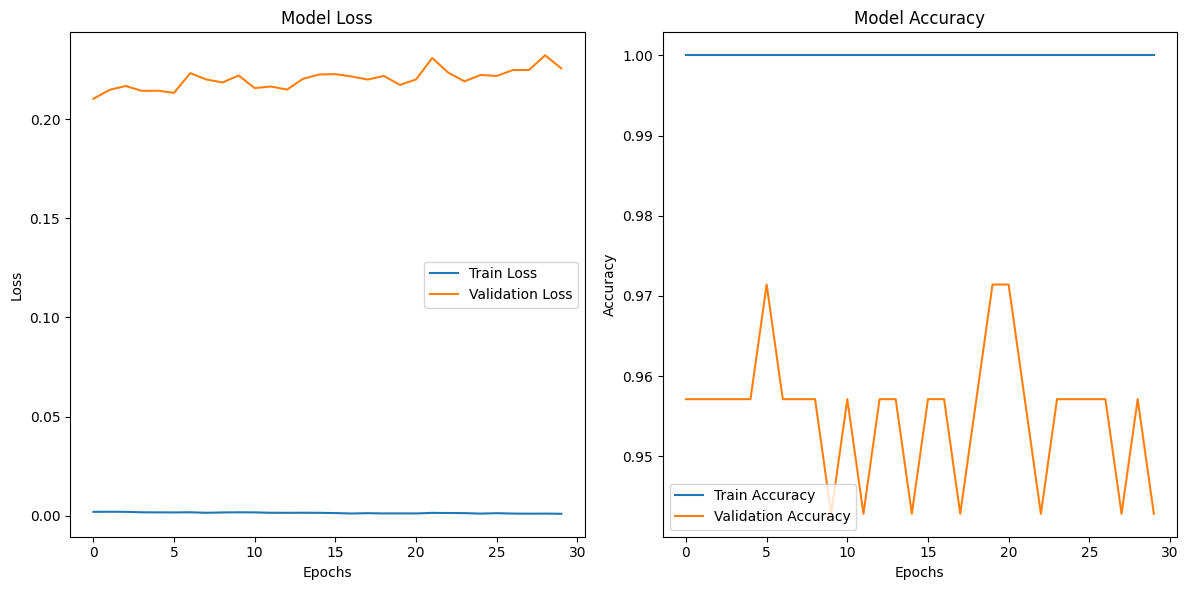

In [16]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

###  Evaluate the model

In [17]:
test_loss, test_accuracy = model.evaluate(test_data)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9558 - loss: 0.1467 
Test Loss: 0.1431695520877838
Test Accuracy: 0.9571428298950195


In [19]:
model_path = "/content/saved_models/best_model.keras"
import os
print("File exists:", os.path.exists(model_path))
model = tf.keras.models.load_model(model_path)

model.summary()


File exists: True


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2048)                │       1,050,6

 Total params: 17,897,297 (68.27 MB)

 Trainable params: 1,060,869 (4.05 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 2,121,740 (8.09 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


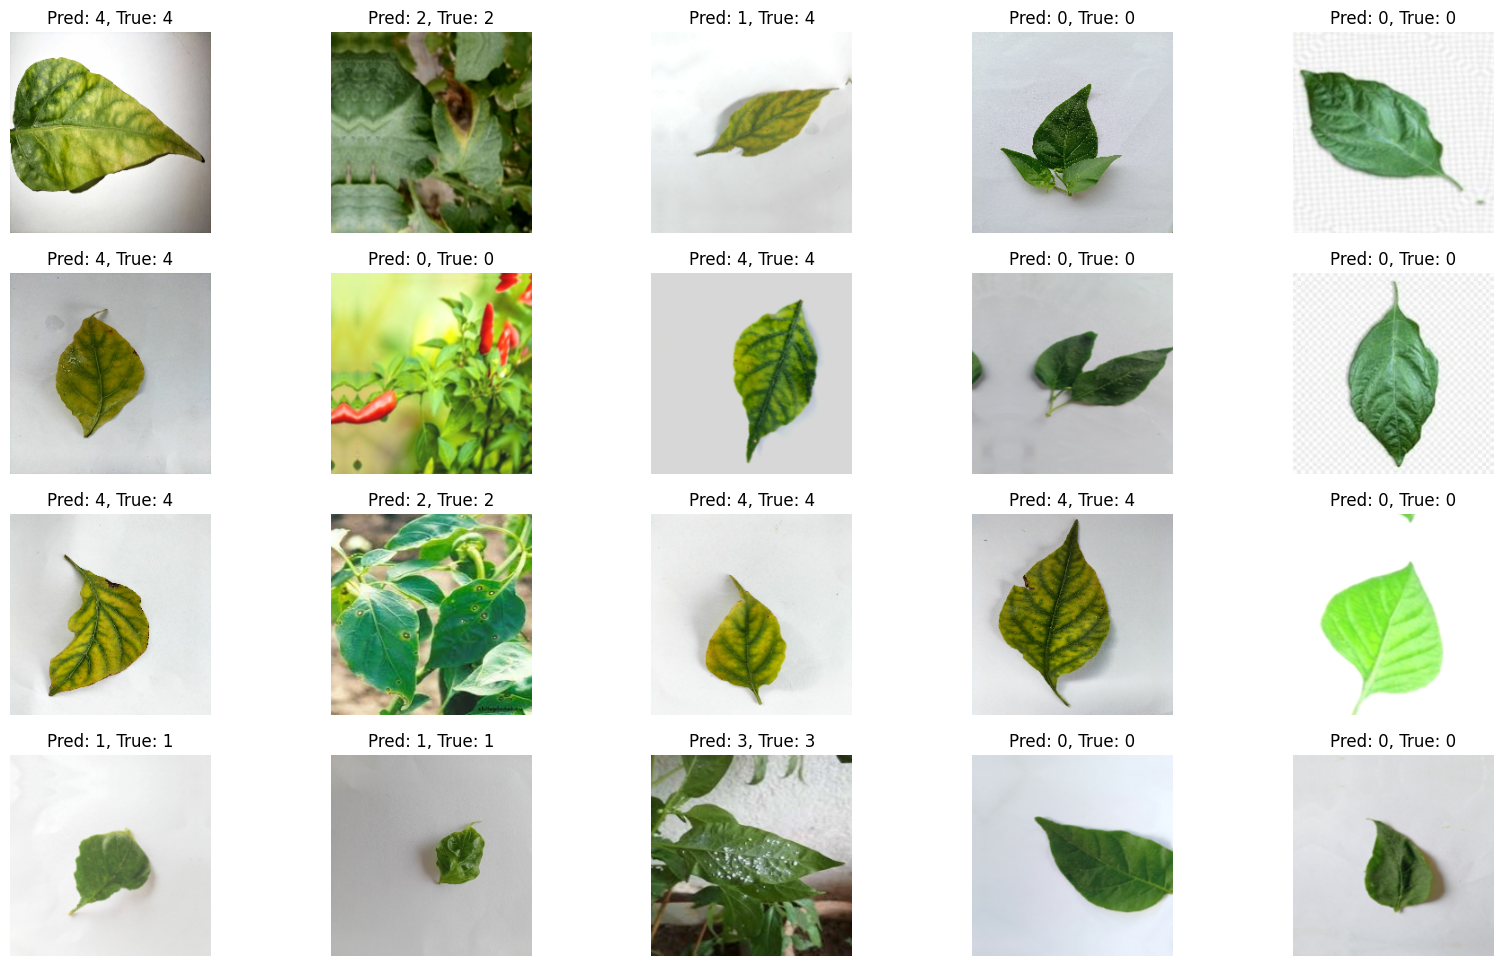

In [20]:
# Visualize predictions on test images
unbatched_data = list(test_data.unbatch())
data=20
image_batch = [item[0] for item in unbatched_data[-data:]]
label_batch = [item[1] for item in unbatched_data[-data:]]

predictions = model.predict(np.array([image.numpy() for image in image_batch]))

plt.figure(figsize=(20, 12))

for i in range(len(image_batch)):
    plt.subplot(4, 5, i+1)

    image_display = image_batch[i].numpy() * 255.0
    image_display = np.clip(image_display, 0, 255).astype("uint8")

    plt.imshow(image_display)
    predicted_class = np.argmax(predictions[i])
    true_class = np.argmax(label_batch[i])
    plt.title(f'Pred: {predicted_class}, True: {true_class}')
    plt.axis('off')

plt.show()


### grand cam visualisasi

In [21]:
def get_grad(img,label):
  grad_model=tf.keras.models.Model(
      inputs=[model.inputs],
      outputs=[model.get_layer("block5_conv3").output,model.output]
  )
  with tf.GradientTape() as tape:

    conv_output_values,predictions=grad_model(img)
    label=tf.expand_dims(label,axis=0)
    loss=tf.keras.losses.categorical_crossentropy(label,predictions)
    print(f"binary loss: {loss}")
  gradient= tape.gradient(loss,conv_output_values)
  # rata ratakan nilai agar dapat gradient untuk setiap chenel / feature bukan pada sitiap pixel nya
  gradient=tf.keras.backend.mean(gradient,axis=(0,1,2)).numpy()

  # hapus dimensi batch
  conv_output_values=np.squeeze(conv_output_values).copy()

  for i in range(len(gradient)):
    # kalikan nilai fiature demgan nilai gradient pada di setiap fiture
    conv_output_values[:,:,i]*=gradient[i]
    # lalu rata rata kan niali apada di setiap feature
  heatmap=np.mean(conv_output_values,axis=-1)
  # normalisasi / agar rentang ke 0-1
  heatmap = np.maximum(heatmap, 0) # relu
  heatmap /= heatmap.max()
  print("heatmap shape",heatmap.shape)


  return heatmap


### show sample

In [24]:
def show_grand_cam(img,label,model):
  outputs = [layer.output for layer in model.layers]
  vis_model=tf.keras.models.Model(
      inputs=[model.inputs],
      outputs=outputs
  )

  img=tf.expand_dims(img,axis=0)

  feature=vis_model.predict(img)
  sample_feature = feature[2][0,:,:,1] #get sample fiture

  sample_feature-=sample_feature.mean()
  sample_feature/=sample_feature.std()
  sample_feature *=255

  sample_feature = np.clip(sample_feature, 0, 255).astype(np.uint8)

  heatmap=get_grad(img,label)
  heatmap=cv2.resize(heatmap,(img.shape[2], img.shape[1]))
  heatmap=np.uint8(255*heatmap)
  heatmap=np.clip(heatmap, 0, 255).astype(np.uint8)
  heatmap=cv2.applyColorMap(heatmap,cv2.COLORMAP_HOT)
  converted_img = img[0].numpy()

  super_imposed_image = cv2.addWeighted(converted_img, 0.8, heatmap.astype('float32'), 2e-3, 0.0)

# show
  f,ax = plt.subplots(2,2, figsize=(15,8))
  img=img[0]

  ax[0,0].imshow(img)
  ax[0,0].set_title(f"True label:{np.argmax(label)}  \n")
  ax[0,0].axis('off')

  ax[0,1].imshow(sample_feature)
  ax[0,1].set_title("Random feature map")
  ax[0,1].axis('off')

  ax[1,0].imshow(heatmap)
  ax[1,0].set_title("Class Activation Map")
  ax[1,0].axis('off')

  ax[1,1].imshow(super_imposed_image)
  ax[1,1].set_title("Activation map superimposed")
  ax[1,1].axis('off')
  plt.tight_layout()
  plt.show()


In [25]:
unbatched_data = list(test_data.unbatch())
# Assuming the first two elements of each unbatched item are image and label
data=20
image_batch = [item[0] for item in unbatched_data[-data:]]
label_batch = [item[1] for item in unbatched_data[-data:]]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
binary loss: [0.00100848]


heatmap shape (14, 14)


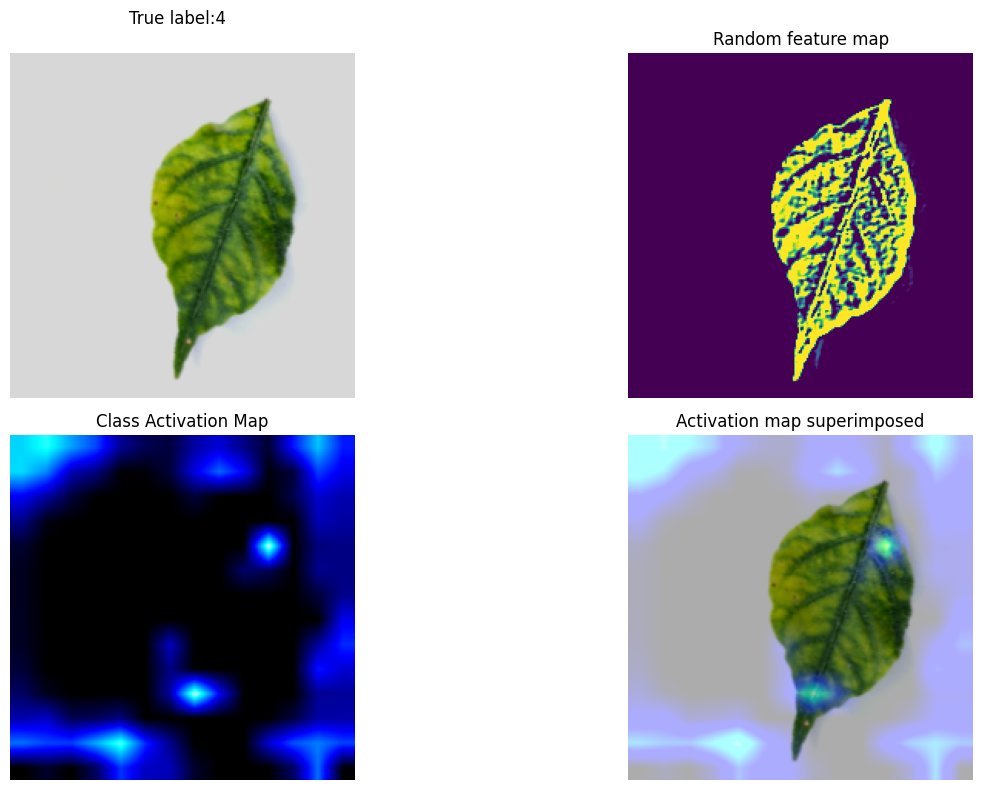

In [26]:
model = tf.keras.models.load_model('/content/saved_models/best_model.keras')
idx=7
show_grand_cam(image_batch[idx],label_batch[idx],model)

### save model

In [ ]:
model.save('/content/saved_modelsss/best_model.keras')

model_test = tf.keras.models.load_model('/content/saved_models/best_model.keras')
model_test.load_weights('/content/saved_modelsss/best_model.keras')
model_test.save('./test/model_test.h5')